In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

os.environ['CUDA_VISIBLE_DEVICES']="1"


from os.path import exists


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )

print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1


of_niter = 5





input_dir = 'input-samples-smearing-0.00-v1b'


output_dir = 'hist-pdf-study-1d-read-input-v1b-smearing-0.00'



#-- parameters for simple pdf

hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.10

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins



 window_nbins : 5


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.1,
 'window_nbins': 5}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
config_file = open('%s/config.txt' % output_dir, 'w' )

config_file.write('  input_dir  %s\n' % input_dir )
config_file.write(' of_niter %d\n' % of_niter )
config_file.write( 'hist pars %s\n' % str(hist_pars) )
config_file.close()

print( subprocess.getoutput('cat %s/config.txt' % output_dir ))



  input_dir  input-samples-smearing-0.00-v1b
 of_niter 5
hist pars {'low': -10.0, 'high': 10.0, 'nbins': 1000, 'binwidth': 0.02, 'window_dx': 0.1, 'window_nbins': 5}


## Count the number of samples in the input directory and read in the first one

In [7]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/sample-%04d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [8]:
def read_sample( input_dir, sample_index ) :
    
    with open( '%s/sample-%04d.npy' % (input_dir, sample_index), 'rb' ) as f :
        read_true_pts = np.load(f)
        read_true_det_pts = np.load(f)
        read_train_pts = np.load(f)
        read_train_det_pts = np.load(f)

    ngen_true = len(read_true_pts)
    ngen_train = len(read_train_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    true_pts = np.zeros( shape=(ngen_true,1) )
    true_pts[:,0] = read_true_pts

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    train_pts = np.zeros( shape=(ngen_train,1) )
    train_pts[:,0] = read_train_pts

    train_det_pts = np.zeros( shape=(ngen_train,1) )
    train_det_pts[:,0] = read_train_det_pts
    
    return_dict = {}
    
    return_dict['true_pts'] = true_pts
    return_dict['true_det_pts'] = true_det_pts
    return_dict['train_pts'] = train_pts
    return_dict['train_det_pts'] = train_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_train'] = ngen_train
    
    return return_dict
    
    

In [9]:

rd = read_sample( input_dir, 0 )

ngen_true = rd['ngen_true']
ngen_train = rd['ngen_train']

true_pts = rd['true_pts']
true_det_pts = rd['true_det_pts']
train_pts = rd['train_pts']
train_det_pts = rd['train_det_pts']


print('  true_pts:   ngen_true  = %8d,  shape = %s' % (ngen_true, str(true_pts.shape)) )
print('  train_pts:  ngen_train = %8d,  shape = %s' % (ngen_train, str(train_pts.shape)) )


  true_pts:   ngen_true  =     9924,  shape = (9924, 1)
  train_pts:  ngen_train =   100000,  shape = (100000, 1)


## Function that estimates the pdf from a histogram (multi-bin sum)

In [10]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

## Define OmniFold implementation with Simple pdf

In [11]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    of_ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = of_ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*of_ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    

    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        


        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( of_ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
        #if verbose : print(' calculation of model pars with push weights')
        #model_pars_theta0_G_push_weight = calc_model_pars( weights_push, theta0_G, verbose )

        #if verbose : print(' calculation of model pars with pull weights')
        #model_pars_theta0_G_pull_weight = calc_model_pars( weights_pull, theta0_G, verbose )
        
        #pdf_ratio_step2 = calc_pdf_ratio( model_pars_theta0_G_pull_weight['mean'],
        #                           model_pars_theta0_G_push_weight['mean'],
        #                           model_pars_theta0_G_pull_weight['cov'],
        #                           model_pars_theta0_G_push_weight['cov'],
        #                           theta0_G )        

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [12]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

In [13]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (9924, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 9924





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[1.12326957 1.03423785 1.14473472 ... 1.1411625  0.34597707 0.52068584]
  iter 1, step1_output_weights:  shape (100000,)
[1.12326957 1.03423785 1.14473472 ... 1.1411625  0.34597707 0.52068584]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[1.13803665 1.02235045 1.1475048  ... 1.12353847 0.37667345 0.54601147]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[1.13803665 1.02235045 1.1475048  ... 1.12353847 0.37667345 0.54601147]
 pdf_ratio_step1:  shape (100000,) 
[0.9854635  1.01693355 0.99658913 ... 1.01737731 0.90248136 0.93195064]
  iter 2, step1

In [14]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

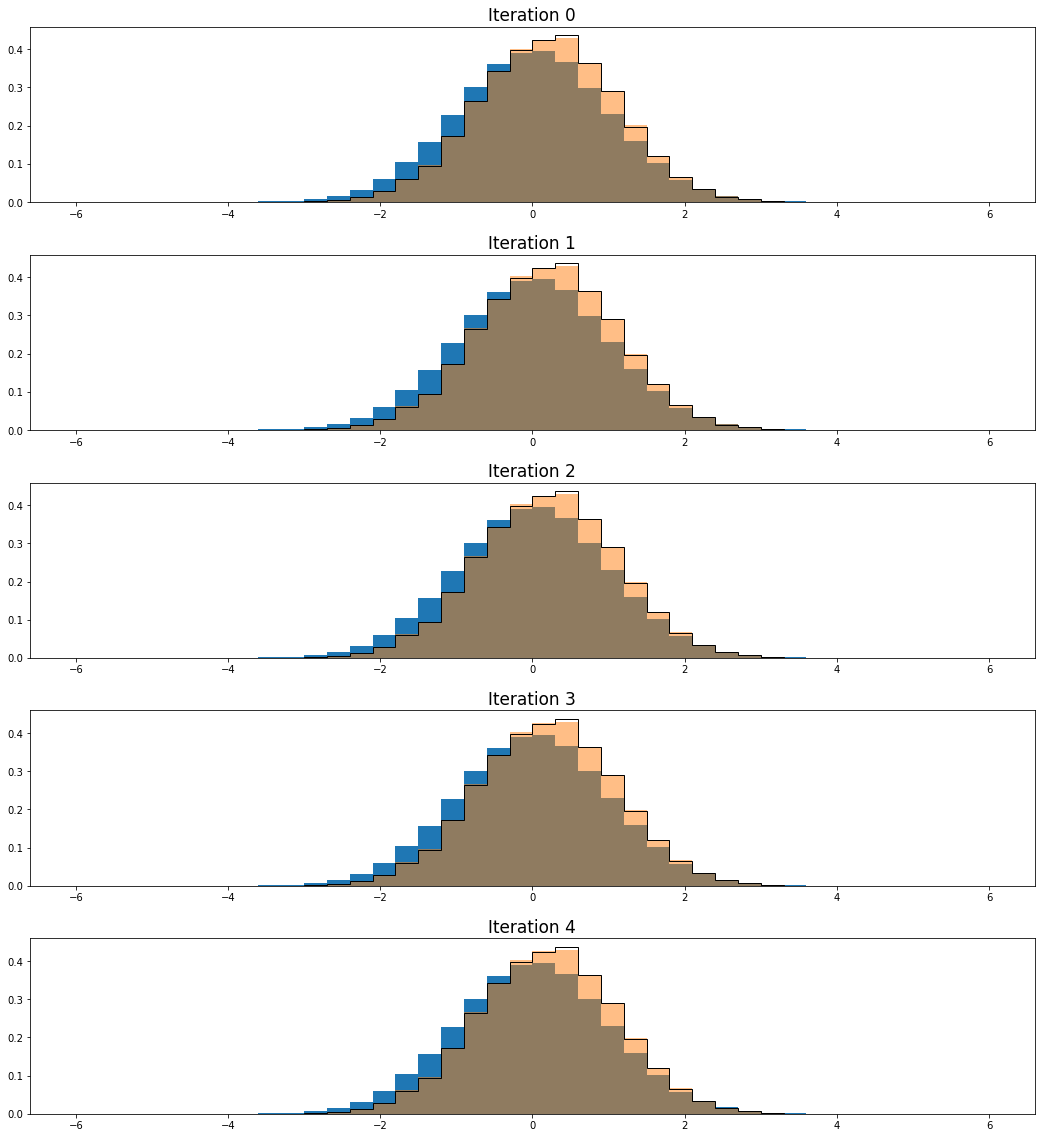

In [15]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            #hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        
            #hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [16]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

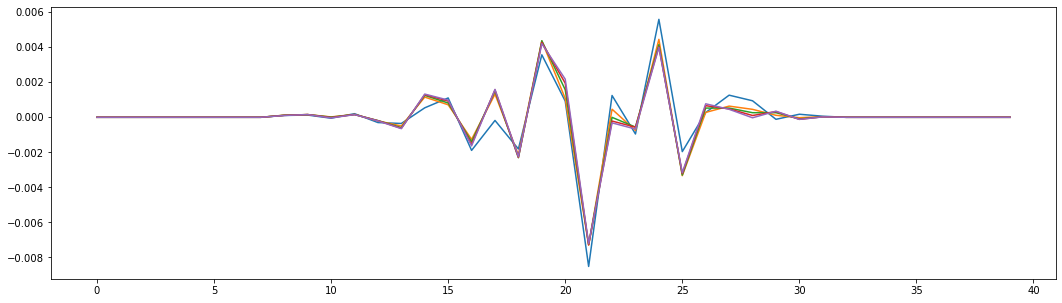

In [17]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

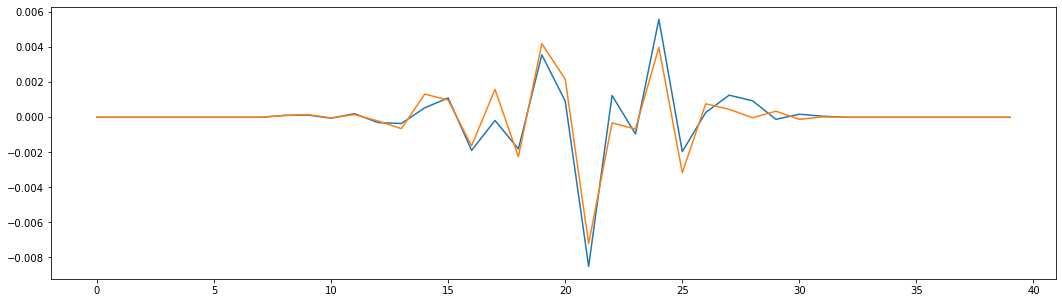

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

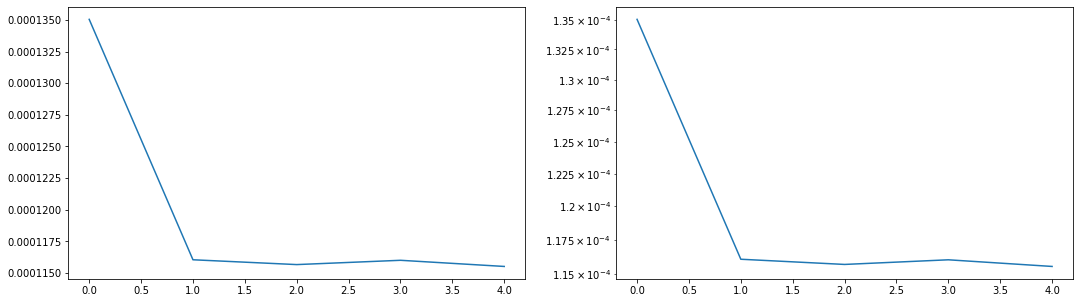

In [19]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

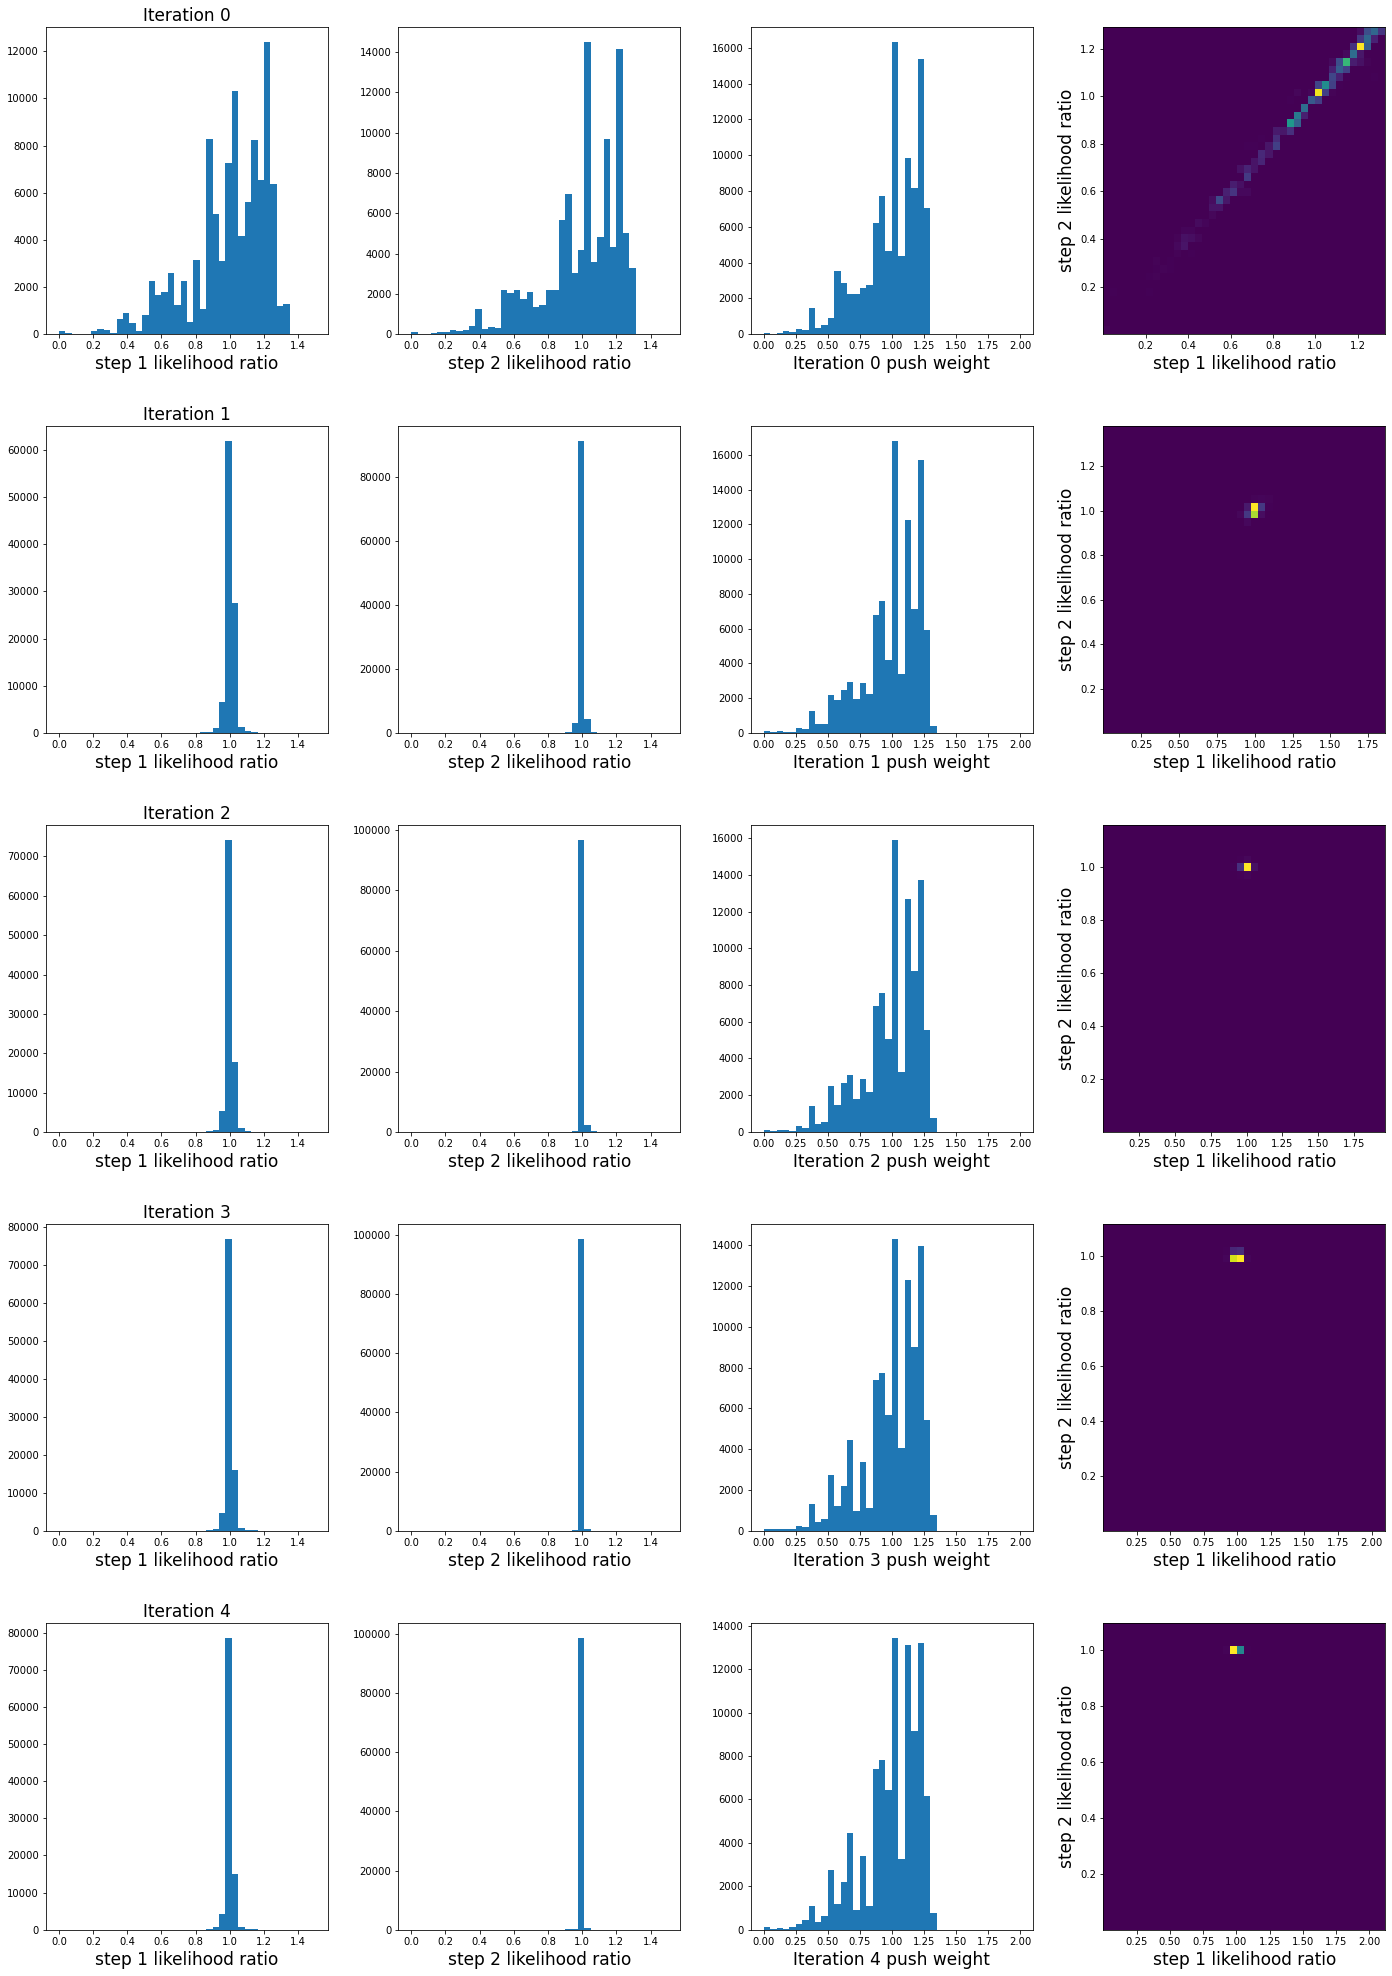

In [20]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    #ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

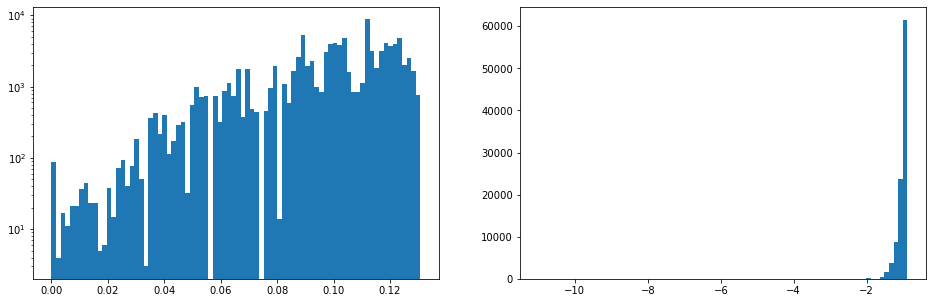

In [21]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

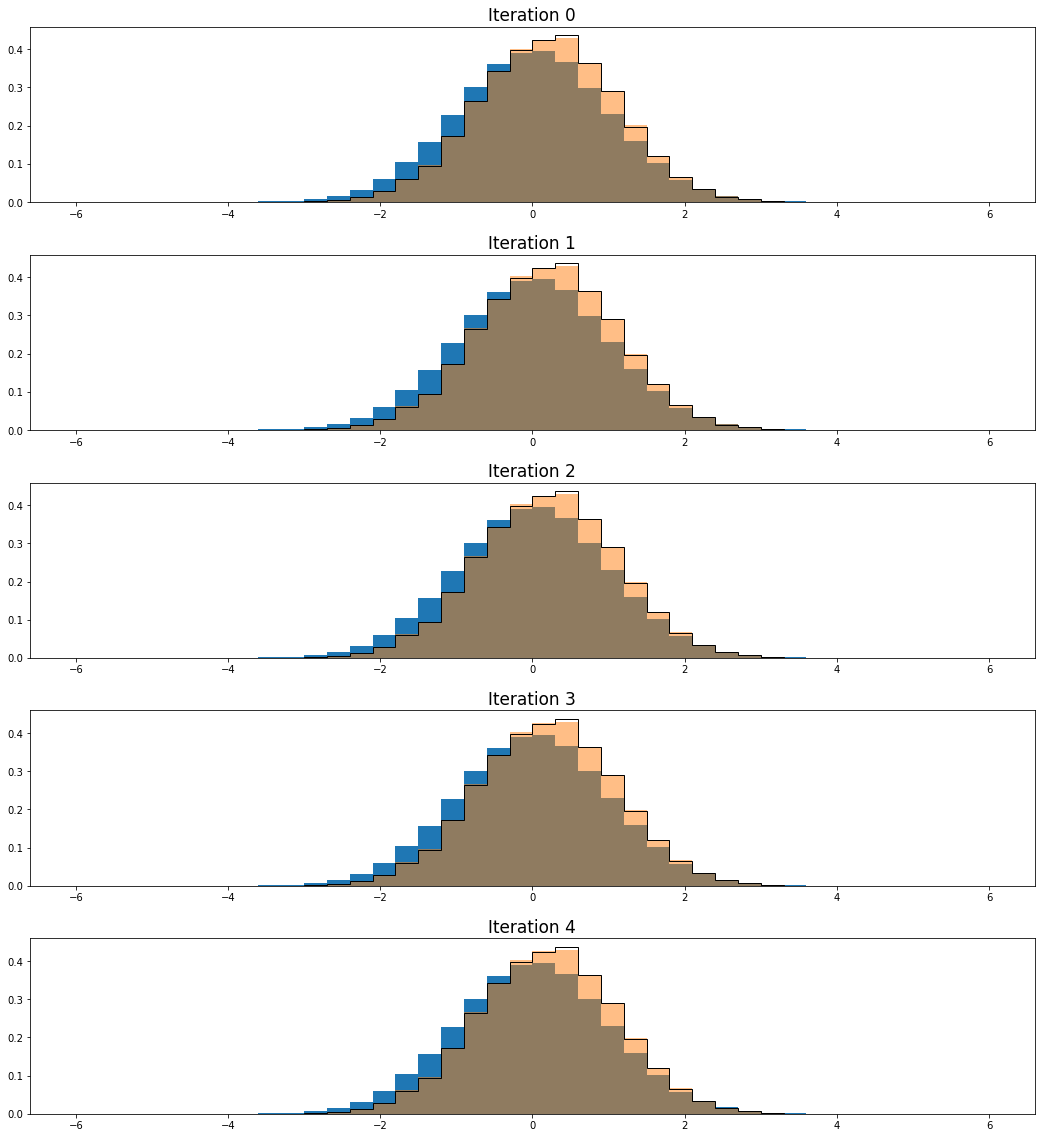

In [22]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            #det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            
    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            
            #det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [23]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

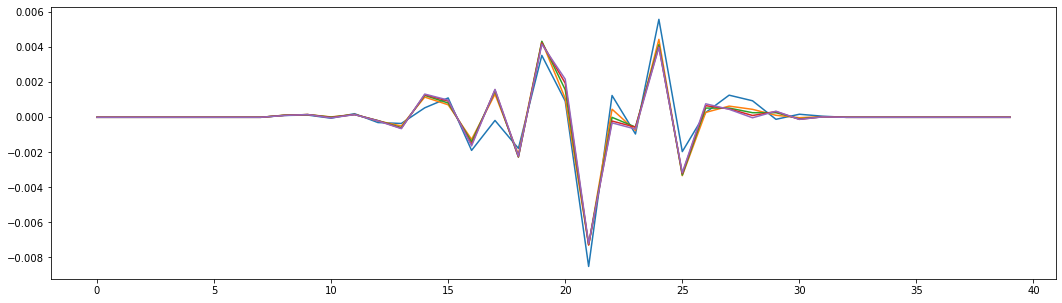

In [24]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

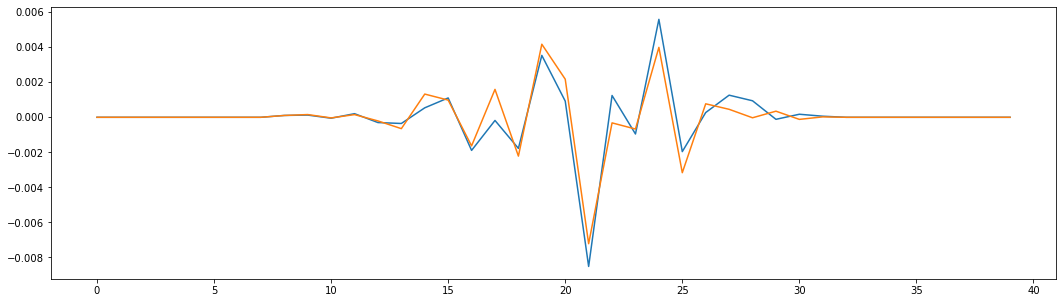

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

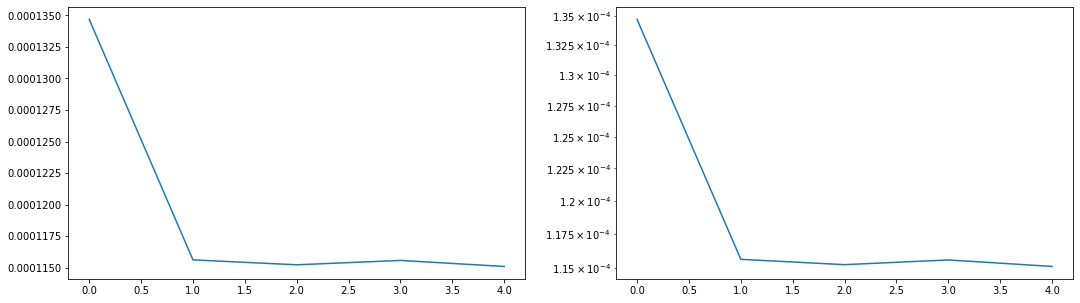

In [26]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [27]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.998  rms 0.227      step 2 mean  0.998  rms 0.226
  iter  1 : step 1 mean  0.999  rms 0.044      step 2 mean  1.000  rms 0.023
  iter  2 : step 1 mean  0.999  rms 0.041      step 2 mean  0.999  rms 0.018
  iter  3 : step 1 mean  0.999  rms 0.040      step 2 mean  1.000  rms 0.017
  iter  4 : step 1 mean  0.999  rms 0.039      step 2 mean  1.000  rms 0.016


<function matplotlib.pyplot.show(close=None, block=None)>

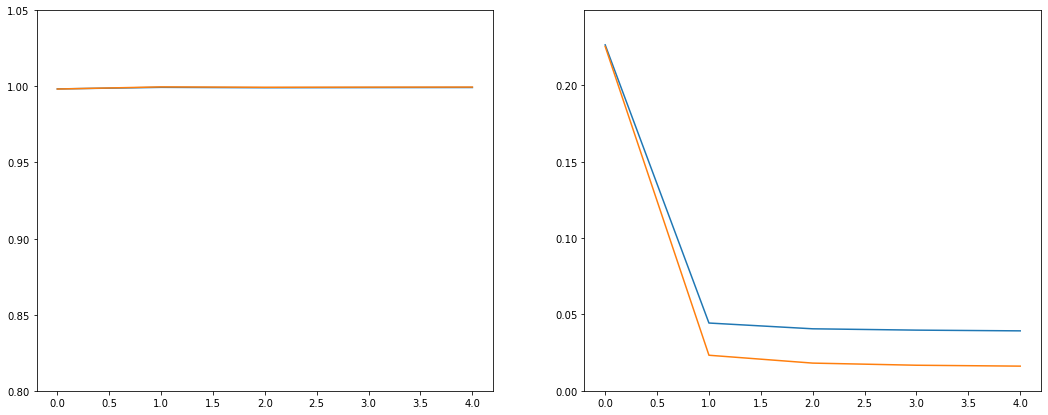

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

In [29]:

verbose = False



import gc

In [30]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_samples) :

    print('\n\n\n ==== processing sample %6d' % bi )
        
    rd = read_sample( input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    train_both = np.stack([train_pts, train_det_pts], axis=1)
        
    
    rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    




 ==== processing sample      0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.13803665 1.02235045 1.1475048  ... 1.12353847 0.37667345 0.54601147]
 weights_push at the beginning
[1.13583542 1.03105928 1.14168543 ... 1.12869473 0.36633542 0.52510443]
 weights_push at the beginning
[1.13152506 1.03381712 1.14310254 ... 1.12938155 0.36199571 0.51536337]
 weights_push at the beginning
[1.12798961 1.03475512 1.14348373 ... 1.12833596 0.35986506 0.51037944]


 bootstrap 0 final push weights scaled:
[0.11170449 0.10272529 0.11352428 ... 0.11182252 0.03558759 0.05036345]



 ==== processing sample      1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18413978 1.06740402 1.08538799 ... 1.28664636 0.86180831 0.9547235 ]
 weights_push at the beginning
[1.16940986 1.01905661 1.06969792 ... 1.28563786 0.86308695 0.95684937]
 weights_push at the beginning
[1.15844343 1.00190694 1.0603457  ... 1.28087857 0.86174166




 ==== processing sample     14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90891417 1.17415237 1.1075594  ... 0.95348464 0.60180168 1.1884828 ]
 weights_push at the beginning
[0.90370314 1.13688833 1.11410744 ... 0.96061599 0.59238216 1.19805786]
 weights_push at the beginning
[0.90148043 1.11851593 1.11378236 ... 0.96708898 0.57988909 1.20449679]
 weights_push at the beginning
[0.90022693 1.10627895 1.1118171  ... 0.97215269 0.56868205 1.20886746]


 bootstrap 14 final push weights scaled:
[0.08849752 0.1079606  0.10915968 ... 0.0960592  0.05502915 0.1192586 ]



 ==== processing sample     15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98734955 1.09418711 0.63624179 ... 0.96027139 0.80341181 1.19017951]
 weights_push at the beginning
[0.98818609 1.09438566 0.63458337 ... 0.96762159 0.79072538 1.17707984]
 weights_push at the beginning
[0.9894016  1.09580774 0.6351066  ... 0.96784884 0.7843496




 ==== processing sample     28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.10831246 1.16498598 0.72636242 ... 1.03723319 0.89320479 1.15872881]
 weights_push at the beginning
[1.06134364 1.14925978 0.74877814 ... 1.04666859 0.91069716 1.17594042]
 weights_push at the beginning
[1.03883597 1.13707898 0.76105781 ... 1.05073299 0.91985827 1.18343012]
 weights_push at the beginning
[1.02415757 1.12906629 0.76855188 ... 1.05385183 0.92632355 1.18862635]


 bootstrap 28 final push weights scaled:
[0.10114836 0.11217967 0.07722421 ... 0.10552838 0.09301037 0.11905377]



 ==== processing sample     29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.20728034 0.79542246 1.09647321 ... 1.03056738 0.70445012 1.06092083]
 weights_push at the beginning
[1.19903165 0.78704566 1.09413105 ... 1.04313199 0.71293287 1.05599637]
 weights_push at the beginning
[1.1972766  0.78036408 1.09343832 ... 1.05147012 0.7161960




 ==== processing sample     42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18434323 0.61655935 1.04383447 ... 0.67919856 0.92818191 0.90849762]
 weights_push at the beginning
[1.17074495 0.61120003 1.04480838 ... 0.69037194 0.93707187 0.9174951 ]
 weights_push at the beginning
[1.16476628 0.61214293 1.04405405 ... 0.69875542 0.94144668 0.92346101]
 weights_push at the beginning
[1.16297115 0.61410644 1.04354825 ... 0.70424805 0.94426507 0.9279748 ]


 bootstrap 42 final push weights scaled:
[0.11548222 0.06114757 0.10356651 ... 0.07027081 0.09396672 0.09249964]



 ==== processing sample     43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16974417 0.84379    1.16909562 ... 1.06687904 1.21867476 1.2224631 ]
 weights_push at the beginning
[1.14445005 0.85290454 1.14720315 ... 1.06916097 1.20810006 1.22796066]
 weights_push at the beginning
[1.1398332  0.85872387 1.13700024 ... 1.07001319 1.2021394




 ==== processing sample     56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.3616918  1.10489515 1.06082107 ... 0.58271808 1.07580793 0.95770088]
 weights_push at the beginning
[1.3969654  1.09559636 1.07428899 ... 0.58376405 1.07211147 0.9704976 ]
 weights_push at the beginning
[1.41776799 1.09069081 1.08249463 ... 0.58180476 1.06697532 0.97405404]
 weights_push at the beginning
[1.4298796  1.08709707 1.08922191 ... 0.58048153 1.06264129 0.97544542]


 bootstrap 56 final push weights scaled:
[0.1435619  0.10834181 0.10936981 ... 0.05792612 0.10582147 0.09751595]



 ==== processing sample     57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98051938 1.17664065 1.03116591 ... 0.68691154 0.94430189 0.99712411]
 weights_push at the beginning
[0.98503991 1.1680485  1.03000174 ... 0.6857687  0.94572211 1.0072511 ]
 weights_push at the beginning
[0.98488423 1.16168984 1.02969198 ... 0.6822791  0.9457646




 ==== processing sample     70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.23919878 0.7799868  1.11268277 ... 1.21372017 0.91269939 1.21372017]
 weights_push at the beginning
[1.23367573 0.78580988 1.11143976 ... 1.22290779 0.92222769 1.22290779]
 weights_push at the beginning
[1.23133888 0.78552835 1.10890177 ... 1.22540416 0.92741635 1.22540416]
 weights_push at the beginning
[1.22969849 0.78480484 1.10638426 ... 1.22682493 0.93068337 1.22682493]


 bootstrap 70 final push weights scaled:
[0.1205509  0.07696034 0.10835901 ... 0.12052775 0.09155359 0.12052775]



 ==== processing sample     71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09124511 0.5439077  0.98851703 ... 1.20829853 1.15731571 1.08362133]
 weights_push at the beginning
[1.10540628 0.53217376 0.97421255 ... 1.1956145  1.16378266 1.07148703]
 weights_push at the beginning
[1.11177977 0.52483824 0.96191384 ... 1.18863898 1.1679317




 ==== processing sample     84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16078208 1.09613969 0.9894058  ... 0.87516149 0.50083033 1.24618835]
 weights_push at the beginning
[1.1378388  1.09533149 0.96607058 ... 0.8806561  0.51085583 1.26431451]
 weights_push at the beginning
[1.13046671 1.09290653 0.96605049 ... 0.87932117 0.51502269 1.27709188]
 weights_push at the beginning
[1.12869334 1.09096205 0.97083518 ... 0.87730689 0.51677663 1.28340946]


 bootstrap 84 final push weights scaled:
[0.11139071 0.10751714 0.09642996 ... 0.08637466 0.05103821 0.12687132]



 ==== processing sample     85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.45121728 0.88611899 1.13944293 ... 1.12323182 1.2318159  0.97656095]
 weights_push at the beginning
[0.44313715 0.88394187 1.16524127 ... 1.13151535 1.23773656 0.9742733 ]
 weights_push at the beginning
[0.43783012 0.88053821 1.18523192 ... 1.13182193 1.2426055




 ==== processing sample     98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16401273 0.74861354 0.89038534 ... 1.28136508 1.01811767 0.49321449]
 weights_push at the beginning
[1.18154378 0.73964051 0.89219245 ... 1.29201799 1.01925364 0.49644976]
 weights_push at the beginning
[1.18876795 0.73475863 0.89083495 ... 1.30163983 1.01934776 0.49869385]
 weights_push at the beginning
[1.19353035 0.73253037 0.88931913 ... 1.30995215 1.01998478 0.50072446]


 bootstrap 98 final push weights scaled:
[0.11983213 0.07324192 0.08887901 ... 0.13192873 0.10217961 0.05033971]



 ==== processing sample     99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18345404 1.08008418 0.96445812 ... 1.14170617 0.67685478 1.18507854]
 weights_push at the beginning
[1.18543734 1.07226963 0.96232625 ... 1.14444695 0.67905395 1.17466284]
 weights_push at the beginning
[1.19116016 1.06952988 0.95724352 ... 1.14557149 0.6826899




 ==== processing sample    112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09463502 1.2177392  1.1295804  ... 0.96538329 0.91094897 0.86733863]
 weights_push at the beginning
[1.09754936 1.21165107 1.14159942 ... 0.97091725 0.91853522 0.87308862]
 weights_push at the beginning
[1.09858486 1.21504482 1.14782989 ... 0.96918011 0.92020763 0.87569737]
 weights_push at the beginning
[1.09870654 1.21976272 1.15187946 ... 0.9667435  0.92060775 0.87699998]


 bootstrap 112 final push weights scaled:
[0.11059086 0.12324694 0.11627461 ... 0.09709471 0.09269364 0.088355  ]



 ==== processing sample    113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.15495175 1.23348679 1.04504124 ... 1.05254255 1.11207709 1.18203268]
 weights_push at the beginning
[1.20968785 1.24337934 1.03933948 ... 1.05179573 1.12002874 1.1701801 ]
 weights_push at the beginning
[1.25751017 1.25045427 1.04119722 ... 1.04693669 1.124805




 ==== processing sample    126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.75837686 1.22102443 1.08753502 ... 1.13547667 1.22746589 1.25228834]
 weights_push at the beginning
[0.75368117 1.21529207 1.05978883 ... 1.11546007 1.23245171 1.24041711]
 weights_push at the beginning
[0.75166426 1.21127217 1.04618639 ... 1.11255378 1.23354104 1.23271962]
 weights_push at the beginning
[0.75115023 1.20903966 1.03735818 ... 1.11120451 1.2342613  1.22662967]


 bootstrap 126 final push weights scaled:
[0.07455367 0.11982837 0.10240794 ... 0.11010922 0.12252555 0.1212358 ]



 ==== processing sample    127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.80843301 0.78958504 1.09036325 ... 1.10588623 0.40820838 0.86971768]
 weights_push at the beginning
[0.80842298 0.78674254 1.07845499 ... 1.11639723 0.42136554 0.86841909]
 weights_push at the beginning
[0.80963563 0.780018   1.07538307 ... 1.12003947 0.426847




 ==== processing sample    140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.27068419 1.21181723 0.86257986 ... 0.95701777 0.84719903 1.28879271]
 weights_push at the beginning
[1.26734202 1.23019704 0.88209365 ... 1.07834341 0.8622028  1.30330787]
 weights_push at the beginning
[1.26187661 1.23775031 0.89441997 ... 1.1088983  0.87247243 1.31034839]
 weights_push at the beginning
[1.25683927 1.24059374 0.90252058 ... 1.11115744 0.87961046 1.31408486]


 bootstrap 140 final push weights scaled:
[0.12578941 0.12462883 0.09114039 ... 0.11111981 0.08879018 0.13218033]



 ==== processing sample    141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.00326562 1.01925945 0.82640639 ... 1.15613139 1.27779887 0.60440481]
 weights_push at the beginning
[1.00761535 1.02486566 0.82761869 ... 1.1540765  1.31416025 0.6070921 ]
 weights_push at the beginning
[1.00621658 1.02530376 0.82904576 ... 1.15207946 1.338439




 ==== processing sample    154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.06371897 1.07846246 1.25643391 ... 0.93986112 1.06943488 1.26066546]
 weights_push at the beginning
[1.07240438 1.07335631 1.25844091 ... 0.95405915 1.06929733 1.26610334]
 weights_push at the beginning
[1.07832202 1.07224072 1.25603363 ... 0.95944344 1.06752605 1.26439211]
 weights_push at the beginning
[1.0827005  1.07247296 1.25468462 ... 0.96364328 1.06515694 1.26256948]


 bootstrap 154 final push weights scaled:
[0.10951381 0.10818954 0.12646322 ... 0.09753147 0.10714047 0.12715988]



 ==== processing sample    155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.07703735 0.8158525  1.00688288 ... 1.18191589 1.18898206 0.64529902]
 weights_push at the beginning
[1.08103504 0.81534686 1.01603531 ... 1.18546194 1.19769295 0.63708159]
 weights_push at the beginning
[1.08493848 0.81319659 1.02113972 ... 1.18801446 1.209848




 ==== processing sample    168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.46909503 0.69204109 0.68775218 ... 0.39880562 0.83400359 1.05466194]
 weights_push at the beginning
[0.45477021 0.68520953 0.67347712 ... 0.40962404 0.84122763 1.04847732]
 weights_push at the beginning
[0.4506768  0.68045196 0.66450074 ... 0.42430881 0.84165565 1.0461116 ]
 weights_push at the beginning
[0.44962629 0.67897456 0.659364   ... 0.44100398 0.84041727 1.04460129]


 bootstrap 168 final push weights scaled:
[0.04526866 0.06840297 0.06605806 ... 0.04607214 0.08448325 0.10501631]



 ==== processing sample    169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.84079486 1.21859434 1.22190347 ... 1.05315422 1.06662688 0.91323924]
 weights_push at the beginning
[0.83776907 1.21345376 1.21777642 ... 1.05109875 1.06223703 0.90991291]
 weights_push at the beginning
[0.83809508 1.20758841 1.2136956  ... 1.0491482  1.063446




 ==== processing sample    182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.24959294 1.02202114 0.91711297 ... 0.95242363 1.20628819 1.13843812]
 weights_push at the beginning
[1.26697423 1.02398178 0.90947826 ... 0.95665487 1.21280479 1.10975088]
 weights_push at the beginning
[1.28197666 1.02673577 0.90014085 ... 0.95747879 1.21529461 1.09497739]
 weights_push at the beginning
[1.294884   1.02853751 0.8928738  ... 0.95811791 1.2181819  1.08546981]


 bootstrap 182 final push weights scaled:
[0.12844534 0.10122302 0.08725059 ... 0.09425496 0.12010309 0.10607536]



 ==== processing sample    183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.2815756  0.5460298  1.13652636 ... 0.38522371 1.22406909 1.31435239]
 weights_push at the beginning
[1.28836285 0.53379064 1.14419558 ... 0.36742792 1.23501635 1.32849023]
 weights_push at the beginning
[1.29326602 0.52782757 1.1450867  ... 0.35794722 1.242691




 ==== processing sample    196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09191336 1.08955116 0.91164566 ... 0.91248791 1.0130496  0.65211184]
 weights_push at the beginning
[1.0908144  1.09285664 0.9083241  ... 0.90425079 1.00506278 0.64764147]
 weights_push at the beginning
[1.09096607 1.09366759 0.90340711 ... 0.89558381 1.00321437 0.644573  ]
 weights_push at the beginning
[1.09167429 1.09318425 0.90025808 ... 0.88930785 1.00433753 0.6419596 ]


 bootstrap 196 final push weights scaled:
[0.11037683 0.11033399 0.09072703 ... 0.08934501 0.10169569 0.06459056]



 ==== processing sample    197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98095908 1.16862119 0.62457282 ... 0.66500708 1.11658487 1.11511554]
 weights_push at the beginning
[0.99124506 1.16273206 0.62301293 ... 0.66026472 1.30418822 1.11931046]
 weights_push at the beginning
[0.99665191 1.15502786 0.61702205 ... 0.65769952 1.385068




 ==== processing sample    210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96052426 0.90500461 0.72576329 ... 0.71542221 1.21500276 1.24742558]
 weights_push at the beginning
[0.9533523  0.91532699 0.71494185 ... 0.70887881 1.20904243 1.2549603 ]
 weights_push at the beginning
[0.94627732 0.92211136 0.70723043 ... 0.70329181 1.20374846 1.26058119]
 weights_push at the beginning
[0.94132857 0.92770015 0.70269155 ... 0.70066754 1.20051698 1.26560243]


 bootstrap 210 final push weights scaled:
[0.09286329 0.09230361 0.06929403 ... 0.06932262 0.11864295 0.12571191]



 ==== processing sample    211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.85744232 0.57936554 0.59158963 ... 0.98256276 0.81866656 0.85926503]
 weights_push at the beginning
[0.87274349 0.5761205  0.5868891  ... 0.97859911 0.82768887 0.85897788]
 weights_push at the beginning
[0.87830727 0.57757809 0.58675263 ... 0.97692649 0.824248




 ==== processing sample    224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89623363 0.9772712  0.79730047 ... 1.13417296 0.87216663 0.79761184]
 weights_push at the beginning
[0.89172839 0.96313258 0.78857291 ... 1.15945073 0.88119534 0.79432919]
 weights_push at the beginning
[0.88956198 0.95873246 0.77732577 ... 1.16947417 0.88842267 0.78755888]
 weights_push at the beginning
[0.88890617 0.95833219 0.76720378 ... 1.17410003 0.89443944 0.78120136]


 bootstrap 224 final push weights scaled:
[0.08943712 0.0964941  0.07629283 ... 0.11833648 0.09044591 0.07802829]



 ==== processing sample    225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16807472 1.12192656 0.94477374 ... 1.00744422 0.86290999 1.16259693]
 weights_push at the beginning
[1.16977973 1.12051344 0.9438887  ... 1.02641397 0.87437574 1.16826596]
 weights_push at the beginning
[1.16924315 1.11946769 0.9443071  ... 1.03921609 0.879242




 ==== processing sample    238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.28769113 1.15875522 1.17236319 ... 1.19600471 1.30610031 1.13042095]
 weights_push at the beginning
[1.3084548  1.15431877 1.15055113 ... 1.15286507 1.33228419 1.13702625]
 weights_push at the beginning
[1.31882253 1.15238298 1.14282675 ... 1.13163581 1.34446085 1.1408612 ]
 weights_push at the beginning
[1.32328527 1.15199733 1.13895732 ... 1.1205895  1.34968927 1.14339421]


 bootstrap 238 final push weights scaled:
[0.13151568 0.11436501 0.11279794 ... 0.11054628 0.13418317 0.11359997]



 ==== processing sample    239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.15949167 1.1876313  0.57089584 ... 0.86168415 0.39243065 1.30412633]
 weights_push at the beginning
[1.14577912 1.18976835 0.57184264 ... 0.87580146 0.39259314 1.28775885]
 weights_push at the beginning
[1.14068535 1.18837537 0.57081414 ... 0.88221511 0.393907




 ==== processing sample    252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.09171151 1.22700912 0.65588366 ... 1.04548167 0.81318337 1.04548167]
 weights_push at the beginning
[1.1118785  1.22845954 0.66609429 ... 1.06643711 0.8089868  1.06643711]
 weights_push at the beginning
[1.12041957 1.23036946 0.67097847 ... 1.07663441 0.80418257 1.07663441]
 weights_push at the beginning
[1.1259425  1.23210401 0.67390198 ... 1.08259216 0.8006916  1.08259216]


 bootstrap 252 final push weights scaled:
[0.11203614 0.12226226 0.066996   ... 0.10770804 0.07908288 0.10770804]



 ==== processing sample    253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16329847 1.18172707 0.5395017  ... 1.07206553 1.12223592 0.84306876]
 weights_push at the beginning
[1.13152262 1.17708878 0.53146715 ... 1.07716852 1.13546885 0.85242152]
 weights_push at the beginning
[1.11745191 1.18232878 0.5287516  ... 1.07561174 1.140444




 ==== processing sample    266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.75836983 0.73667456 0.90860235 ... 1.21742166 1.19779521 0.97238631]
 weights_push at the beginning
[0.75769469 0.72925373 0.92073597 ... 1.21638083 1.19650222 0.97881524]
 weights_push at the beginning
[0.76346162 0.73078667 0.92484737 ... 1.21813728 1.20138679 0.98170294]
 weights_push at the beginning
[0.76954139 0.73541239 0.92710108 ... 1.21968761 1.20605031 0.98456131]


 bootstrap 266 final push weights scaled:
[0.07660826 0.07322464 0.09184281 ... 0.12075216 0.11961618 0.09762822]



 ==== processing sample    267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.76424805 0.76752273 1.03546149 ... 0.66613748 1.15130331 1.22607365]
 weights_push at the beginning
[0.75004964 0.75060375 1.04750483 ... 0.66100151 1.15344624 1.23373552]
 weights_push at the beginning
[0.73749196 0.73625546 1.05252587 ... 0.65696319 1.151749




 ==== processing sample    280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.64033825 1.11452152 0.61263751 ... 0.87948492 0.8813154  0.89641293]
 weights_push at the beginning
[0.6275737  1.12660213 0.63392386 ... 0.87802546 0.87541556 0.88616141]
 weights_push at the beginning
[0.62347123 1.13005765 0.63987797 ... 0.87686289 0.87208095 0.88089628]
 weights_push at the beginning
[0.62239685 1.13338157 0.64284212 ... 0.87542063 0.8698179  0.87822177]


 bootstrap 280 final push weights scaled:
[0.06254218 0.11432637 0.06486687 ... 0.08783352 0.08727499 0.08815834]



 ==== processing sample    281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.20241537 1.13029747 1.13349357 ... 1.19445188 1.14013687 0.77959796]
 weights_push at the beginning
[1.2219417  1.14307447 1.14393571 ... 1.19684096 1.11771901 0.78380136]
 weights_push at the beginning
[1.23575838 1.1519622  1.15062806 ... 1.19517492 1.108029




 ==== processing sample    294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.81942876 0.87302923 0.97128506 ... 0.97281845 0.65280509 0.97138948]
 weights_push at the beginning
[0.83089431 0.87793623 0.97074159 ... 0.96615421 0.65075742 0.98683727]
 weights_push at the beginning
[0.83726711 0.87527575 0.96621658 ... 0.96227003 0.64692932 0.99283144]
 weights_push at the beginning
[0.84211637 0.87209838 0.96225624 ... 0.96077927 0.64404426 0.99728391]


 bootstrap 294 final push weights scaled:
[0.08369713 0.08598848 0.09481955 ... 0.09499024 0.06351868 0.09900171]



 ==== processing sample    295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.20141505 1.02087395 1.21407165 ... 1.05535517 1.12592158 1.28671548]
 weights_push at the beginning
[1.18630856 0.97901225 1.21627444 ... 1.03970444 1.1001511  1.31054778]
 weights_push at the beginning
[1.18893888 0.9523156  1.22600102 ... 1.03304521 1.084468




 ==== processing sample    308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.78789004 0.47636094 1.03749001 ... 1.10106612 1.01178597 0.6842729 ]
 weights_push at the beginning
[0.79131223 0.47320945 1.04387304 ... 1.09980449 1.03515534 0.68095124]
 weights_push at the beginning
[0.79400608 0.47524996 1.05018415 ... 1.0994855  1.04249871 0.67556249]
 weights_push at the beginning
[0.79622848 0.47794922 1.05421301 ... 1.10039901 1.04552363 0.67168544]


 bootstrap 308 final push weights scaled:
[0.08107376 0.04881287 0.10731078 ... 0.1119625  0.10635668 0.06795581]



 ==== processing sample    309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.24848889 1.17234681 1.27961349 ... 0.42264884 1.22561695 1.22561695]
 weights_push at the beginning
[1.26916024 1.16868704 1.2831434  ... 0.41683024 1.21767413 1.21767413]
 weights_push at the beginning
[1.28291059 1.16880529 1.27955194 ... 0.41013612 1.220989




 ==== processing sample    322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.89197596 1.05827569 0.98238513 ... 0.76704943 1.12024035 0.75433316]
 weights_push at the beginning
[0.8842609  1.06239089 0.98912177 ... 0.76055196 1.12699892 0.7602036 ]
 weights_push at the beginning
[0.8805466  1.06213124 0.99171027 ... 0.75639975 1.13204474 0.76260684]
 weights_push at the beginning
[0.87944752 1.06201527 0.99268457 ... 0.75513778 1.13658644 0.76561688]


 bootstrap 322 final push weights scaled:
[0.08717766 0.10527545 0.09837716 ... 0.07485743 0.11302145 0.07620859]



 ==== processing sample    323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16668499 1.22154116 1.21557516 ... 1.22142282 1.2688413  1.17966876]
 weights_push at the beginning
[1.15508789 1.22321039 1.21863072 ... 1.21948781 1.24625578 1.18741217]
 weights_push at the beginning
[1.14690343 1.22457741 1.2218606  ... 1.21717509 1.233417




 ==== processing sample    336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.56608121 0.9702585  1.04843353 ... 1.25772685 1.24716933 0.95791338]
 weights_push at the beginning
[0.57246006 0.96437508 1.05282283 ... 1.24915145 1.23907338 0.97529933]
 weights_push at the beginning
[0.57225105 0.96233451 1.06072104 ... 1.24573471 1.22944511 0.98739889]
 weights_push at the beginning
[0.57104742 0.96224456 1.06814301 ... 1.24302272 1.22228915 0.99801399]


 bootstrap 336 final push weights scaled:
[0.05701523 0.09632328 0.10750849 ... 0.12408714 0.12169513 0.10073419]



 ==== processing sample    337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.11347674 0.813029   1.07886178 ... 1.20186115 0.96770451 1.29038515]
 weights_push at the beginning
[1.1129596  0.82316024 1.06702368 ... 1.19808214 0.95799348 1.30509285]
 weights_push at the beginning
[1.11396924 0.82996247 1.06121804 ... 1.18995526 0.949708




 ==== processing sample    350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.17177451 1.09564716 1.00073953 ... 0.84521783 0.98843746 1.11144365]
 weights_push at the beginning
[1.15574663 1.09041092 0.99307896 ... 0.84333419 1.00702706 1.11104501]
 weights_push at the beginning
[1.14795913 1.08420765 0.98843078 ... 0.84606194 1.01549915 1.11065978]
 weights_push at the beginning
[1.14079912 1.07961999 0.98675017 ... 0.85018666 1.02019037 1.11180411]


 bootstrap 350 final push weights scaled:
[0.11367588 0.10787919 0.0988443  ... 0.08557868 0.10255191 0.11162833]



 ==== processing sample    351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.40117897 0.6730621  1.23547413 ... 1.20252775 0.6032105  0.96950365]
 weights_push at the beginning
[0.38641458 0.6094261  1.2315479  ... 1.19060611 0.61378956 0.97658827]
 weights_push at the beginning
[0.37613586 0.60362305 1.23149068 ... 1.17956874 0.618841




 ==== processing sample    364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.08443404 1.16372756 0.69616189 ... 1.10856874 0.72740941 0.8047253 ]
 weights_push at the beginning
[1.09368702 1.16756123 0.70545728 ... 1.11773841 0.7156925  0.81226259]
 weights_push at the beginning
[1.10254442 1.168501   0.70784802 ... 1.12236617 0.70793642 0.81753656]
 weights_push at the beginning
[1.10931679 1.16986623 0.70758959 ... 1.12368145 0.70303295 0.82162144]


 bootstrap 364 final push weights scaled:
[0.11086854 0.11662759 0.07029665 ... 0.11176003 0.0696292  0.08207887]



 ==== processing sample    365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91194918 0.85549063 1.29944679 ... 0.67858129 1.22126067 1.25331982]
 weights_push at the beginning
[0.92686685 0.86233242 1.30797546 ... 0.67073435 1.21711728 1.25099987]
 weights_push at the beginning
[0.93250169 0.86488545 1.31221406 ... 0.66175047 1.210045




 ==== processing sample    378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.06125717 0.91378415 0.82702134 ... 1.01273043 0.87953538 1.07252551]
 weights_push at the beginning
[1.05909309 0.91300966 0.8317738  ... 1.02620729 0.88177566 1.07562031]
 weights_push at the beginning
[1.05704511 0.90902024 0.83352198 ... 1.03088041 0.88097076 1.07784785]
 weights_push at the beginning
[1.05608914 0.90579704 0.83486174 ... 1.03338371 0.88034952 1.08037701]


 bootstrap 378 final push weights scaled:
[0.107182   0.09172415 0.08488297 ... 0.10506962 0.08934941 0.1099491 ]



 ==== processing sample    379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.22921837 1.24112957 1.22850262 ... 0.51476215 0.51845454 1.20719358]
 weights_push at the beginning
[1.22131089 1.23905013 1.20807927 ... 0.52471847 0.51293515 1.20087041]
 weights_push at the beginning
[1.21382946 1.23634781 1.19704532 ... 0.52667821 0.510211




 ==== processing sample    392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18265105 1.14595656 0.95523207 ... 1.16668495 0.88523834 0.93265616]
 weights_push at the beginning
[1.19441704 1.14879184 0.95236985 ... 1.16287358 0.81510681 0.93470272]
 weights_push at the beginning
[1.19988224 1.14521946 0.94921831 ... 1.16565721 0.79239276 0.93519835]
 weights_push at the beginning
[1.20435062 1.142108   0.94687976 ... 1.16900959 0.78213247 0.93559233]


 bootstrap 392 final push weights scaled:
[0.11999065 0.11320906 0.09385746 ... 0.11639557 0.07715233 0.09295556]



 ==== processing sample    393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.60264381 0.89546642 1.30948846 ... 1.27823805 0.83994684 1.30949455]
 weights_push at the beginning
[0.62390189 0.90533954 1.32132192 ... 1.27183315 0.86167842 1.32236683]
 weights_push at the beginning
[0.63750928 0.90381142 1.32890651 ... 1.26677205 0.867025




 ==== processing sample    406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9589782  1.21872521 0.52916798 ... 0.63608649 0.46953376 1.14077771]
 weights_push at the beginning
[0.97170947 1.23255123 0.53112    ... 0.62647243 0.45720886 1.155227  ]
 weights_push at the beginning
[0.97809839 1.24025554 0.53301441 ... 0.64984646 0.45082931 1.16018558]
 weights_push at the beginning
[0.98276667 1.24455016 0.53421821 ... 0.674392   0.44602678 1.16058952]


 bootstrap 406 final push weights scaled:
[0.09789635 0.12368098 0.05310323 ... 0.06855283 0.04384084 0.11502659]



 ==== processing sample    407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.29034064 1.17624394 1.15352595 ... 0.91858078 1.14170153 1.15051371]
 weights_push at the beginning
[1.30245169 1.2008873  1.13850681 ... 0.92649302 1.15759083 1.13210182]
 weights_push at the beginning
[1.31028487 1.21311493 1.12590968 ... 0.93009478 1.163696




 ==== processing sample    420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98682962 1.14721175 0.98885509 ... 1.10999613 1.24770134 0.93800043]
 weights_push at the beginning
[0.98345641 1.14583705 0.97838751 ... 1.12060654 1.26110071 0.95460844]
 weights_push at the beginning
[0.97647567 1.14203737 0.97547547 ... 1.12426771 1.2617808  0.96220509]
 weights_push at the beginning
[0.97034685 1.13925994 0.97511183 ... 1.1253099  1.2567641  0.96817702]


 bootstrap 420 final push weights scaled:
[0.09510435 0.11210281 0.09610762 ... 0.11091311 0.12317542 0.0959266 ]



 ==== processing sample    421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.19846637 1.23428906 1.07930592 ... 0.96280216 0.56711255 0.80218086]
 weights_push at the beginning
[1.18330286 1.24696288 1.07282829 ... 0.95890069 0.55201377 0.80434978]
 weights_push at the beginning
[1.17546549 1.25495954 1.06928379 ... 0.95139797 0.543311




 ==== processing sample    434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.24235353 1.17546195 0.43271713 ... 1.12989158 1.2927977  0.82190957]
 weights_push at the beginning
[1.26846941 1.18210221 0.44003406 ... 1.11300866 1.3227763  0.82295164]
 weights_push at the beginning
[1.29178185 1.17874125 0.44686189 ... 1.10631222 1.34661045 0.82343868]
 weights_push at the beginning
[1.30635782 1.1751878  0.45136118 ... 1.10411145 1.3636717  0.82422346]


 bootstrap 434 final push weights scaled:
[0.13111742 0.11696059 0.04529193 ... 0.1100506  0.13721692 0.08233029]



 ==== processing sample    435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.0933278  1.08076044 0.53418638 ... 0.94894439 1.25818061 1.25360664]
 weights_push at the beginning
[1.06831271 1.09180909 0.52289062 ... 0.96763788 1.27914122 1.27549797]
 weights_push at the beginning
[1.06069492 1.09413692 0.51723191 ... 0.97522636 1.292564




 ==== processing sample    448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.19506121 0.45207136 1.24148631 ... 0.64442447 1.18878178 0.89586853]
 weights_push at the beginning
[1.1909989  0.44963037 1.24582203 ... 0.61058196 1.17198492 0.91672145]
 weights_push at the beginning
[1.19334819 0.45035651 1.24520447 ... 0.60946316 1.16626114 0.92455155]
 weights_push at the beginning
[1.19465279 0.45059229 1.24629374 ... 0.6068538  1.16358316 0.92950244]


 bootstrap 448 final push weights scaled:
[0.12081638 0.04554282 0.12625407 ... 0.06090421 0.11743329 0.09440453]



 ==== processing sample    449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16769182 1.1490745  0.71491419 ... 1.1570283  0.67408259 1.21188861]
 weights_push at the beginning
[1.15756371 1.14337416 0.73483884 ... 1.16315921 0.69288535 1.22207898]
 weights_push at the beginning
[1.15050022 1.14336783 0.74289475 ... 1.16447675 0.701846




 ==== processing sample    462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96453369 1.18901453 1.15889137 ... 0.98388614 0.98388614 0.56783909]
 weights_push at the beginning
[0.98463009 1.19219803 1.14209696 ... 0.97202737 0.97202737 0.57816732]
 weights_push at the beginning
[0.99530583 1.19525206 1.14406797 ... 0.96376113 0.96376113 0.58068065]
 weights_push at the beginning
[1.00287038 1.1969024  1.14933179 ... 0.95914335 0.95914335 0.58063977]


 bootstrap 462 final push weights scaled:
[0.10113993 0.12014663 0.11582446 ... 0.0959135  0.0959135  0.05813882]



 ==== processing sample    463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.01420211 1.10312283 1.11538923 ... 1.16503303 0.54783003 1.20786857]
 weights_push at the beginning
[1.01072735 1.08737949 1.11611517 ... 1.16547715 0.53533397 1.20007576]
 weights_push at the beginning
[1.00876391 1.07997293 1.11324805 ... 1.17049921 0.528026




 ==== processing sample    476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.16252907 1.16252907 1.24301015 ... 0.95155205 1.17480936 0.43286236]
 weights_push at the beginning
[1.1412454  1.1412454  1.25138926 ... 0.94920263 1.16601436 0.42803634]
 weights_push at the beginning
[1.13622452 1.13622452 1.25683356 ... 0.94979425 1.16870612 0.42298503]
 weights_push at the beginning
[1.13598783 1.13598783 1.26174427 ... 0.95098858 1.17210318 0.41947903]


 bootstrap 476 final push weights scaled:
[0.11687338 0.11687338 0.13003916 ... 0.09778586 0.12068156 0.04284941]



 ==== processing sample    477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.55142266 1.20055772 1.09416321 ... 1.19170175 1.23304775 1.23805751]
 weights_push at the beginning
[0.54889162 1.19998986 1.08573334 ... 1.19625893 1.24339851 1.20858772]
 weights_push at the beginning
[0.54535707 1.20109048 1.08053492 ... 1.19697906 1.252379




 ==== processing sample    490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18507353 1.22898364 1.16909501 ... 1.15816697 1.19758318 1.16340267]
 weights_push at the beginning
[1.17992148 1.22068314 1.15130079 ... 1.16609539 1.19786838 1.15116121]
 weights_push at the beginning
[1.17900998 1.217445   1.14871439 ... 1.16705694 1.20000538 1.14918598]
 weights_push at the beginning
[1.17636099 1.21480434 1.14894864 ... 1.16659032 1.19979362 1.14709359]


 bootstrap 490 final push weights scaled:
[0.11673896 0.12063767 0.11443469 ... 0.11604019 0.11930353 0.1138997 ]



 ==== processing sample    491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.18086425 0.98238378 1.05166129 ... 0.99868198 0.7422417  1.10845234]
 weights_push at the beginning
[1.19167751 0.98735897 1.0564445  ... 0.9962135  0.74188879 1.106401  ]
 weights_push at the beginning
[1.19712022 0.9880044  1.06001216 ... 0.99629952 0.741444

In [31]:
print('\n\n Done\n\n')



 Done


